<a href="https://colab.research.google.com/github/jmellafe/question_deduplication/blob/master/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary

In [0]:
# import data from the drive 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv' #change dir to your project folder


Mounted at /content/gdrive


In [0]:
# Hend data importing cell 
df = pd.read_csv('/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
#Alex data importing cell

df = pd.read_csv('/content/gdrive/My Drive/project/data/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
# Shuffle the data

df = df.sample(frac=1, random_state = 0).reset_index(drop=True)

# Create train, validation and test datasets
train_portion = 0.7
val_portion = 0.15
test_portion = 0.15

train_idx = int(train_portion * df.shape[0])
val_idx = int((train_portion + val_portion) * df.shape[0])

train = df[:train_idx]
val = df[train_idx:val_idx]
test = df[val_idx:]

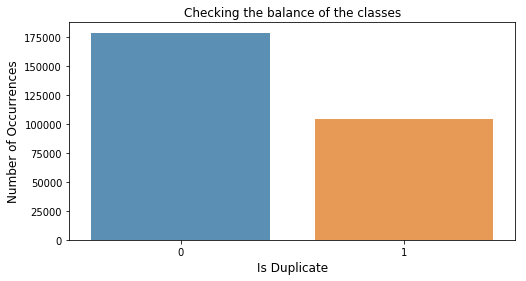

In [0]:
is_dup = train['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.title('Checking the balance of the classes')
plt.show()

In [0]:
is_dup[0]

178510

In [0]:
train.sample(n=is_dup[1], random_state=1)

,id,qid1,qid2,question1,question2,is_duplicate
72971,252076,366315,366316,Where do I find my vehicle registration number...,I own two cars in exactly the same model and c...,0
270716,331043,402448,457880,What are the best places to visit in or near J...,What are the best places to visit in Alaska an...,0
256406,262803,379221,379222,What are the best free business administration...,What are the best free courses online for busi...,1
139439,55899,98492,98493,Can we track the location of a person using a ...,Can I find or track my lost mobile device usin...,1
17579,17836,33834,33835,What are the parts of a river system?,What are the parts of the river?,1
108453,54645,96440,96441,When a balloon is ruptured suddenly what will ...,INTERNAL ENERGY=energy stored in the form of h...,0
16298,334192,461358,293943,Are there any companies in Australia that buil...,How do I make a Rube Goldberg Machine?,0
194913,372711,503445,503446,What are Leonhard Euler's most important inven...,What did Leonhard Euler contribute to calculus?,0
236735,27575,51216,51217,If an 'empty' space is a superfluid and you ro...,In the South cooks used to beat biscuits or ro...,0
6859,316911,442034,442035,How do I prepare for capgemini writen test?,What is the best website for Capgemini written...,0


No handles with labels found to put in legend.


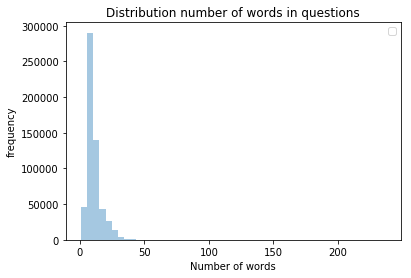

<Figure size 432x288 with 0 Axes>

In [0]:

# HIstogram number of words

temp = train['question1'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp2 = train['question2'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp = pd.concat([temp, temp2]).dropna()

sns.distplot(temp, kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()


No handles with labels found to put in legend.


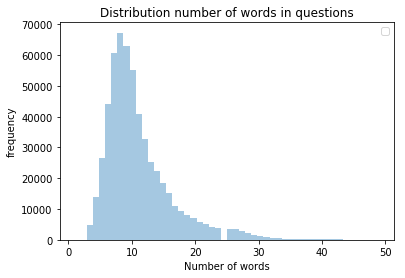

<Figure size 432x288 with 0 Axes>

In [0]:
# detail same plot
sns.distplot(temp[temp < 50], kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()

In [14]:
# simple tokenization just to build the tf-idf feature vector, probably we should replace it for something fancier
train['q1_tokens'] = train['question1'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)
train['q2_tokens'] = train['question2'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:

dctr = Dictionary(train['q1_tokens'].dropna())
dctr.add_documents(train['q2_tokens'].dropna())

[(1, 1), (16, 1), (20, 1), (33, 1), (622, 1), (1128, 2)]